In [1]:
#install packages/libraries
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
!pip install --upgrade numpy==1.26.0 pandas==2.2.2 packaging==24.2.0 pmdarima --user
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
#if error occurs, restart session and run again

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#load csv file
med=pd.read_csv('/content/drive/MyDrive/Grad school stuff/WGU/D213/Task 1/medical_time_series .csv', index_col='Day')
med.head(10)

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888
6,-0.491590
7,-1.255250
8,-1.896279
9,-1.747259


In [4]:
#rename column names to be lowercase
med=med.rename(columns={"Day": "day"})
med=med.rename(columns={"Revenue": "revenue"})
med.head(10)

,revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888
6,-0.491590
7,-1.255250
8,-1.896279
9,-1.747259


In [5]:
med.shape

(731, 1)

In [6]:
#check for duplicates
print(med.duplicated().value_counts())

False    731
Name: count, dtype: int64


In [7]:
#check for missing values
med.isnull().sum().sort_values(ascending=False)

,0
revenue,0


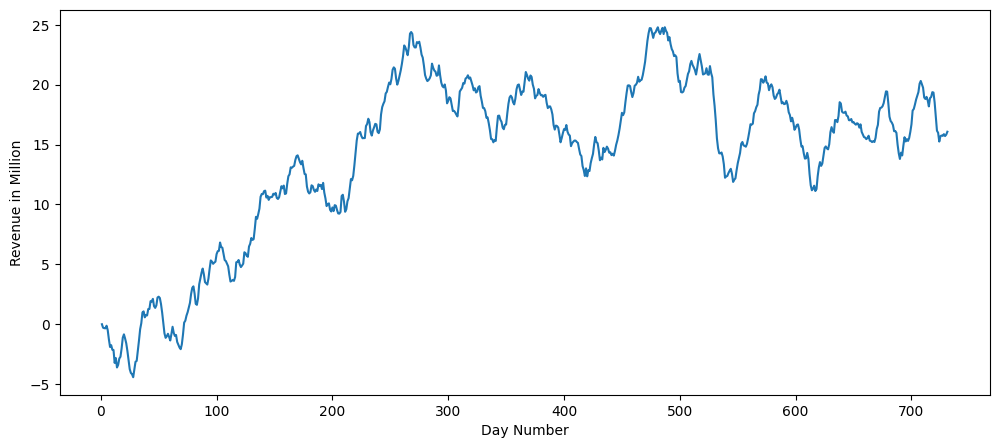

In [8]:
#plot data
med['revenue'].plot(figsize=(12,5))
plt.ylabel('Revenue in Million')
plt.xlabel('Day Number')
plt.show()

In [9]:
#Check for stationarity through the Augmented Dickey-Fuller method (adf)
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF: ", dftest[0])
  print("2. P-value: ", dftest[1])
  print("3. Num of Lags:", dftest[2])
  print("4. Num of Obsd Used for ADF Regression and Critical Values Calc:", dftest[3])
  print("5. Critical Values: ")
  for key, val in dftest[4].items():
    print("\t",key,": ", val)
ad_test(med['revenue'])

1. ADF:  -2.218319047608945
2. P-value:  0.19966400615064372
3. Num of Lags: 1
4. Num of Obsd Used for ADF Regression and Critical Values Calc: 729
5. Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


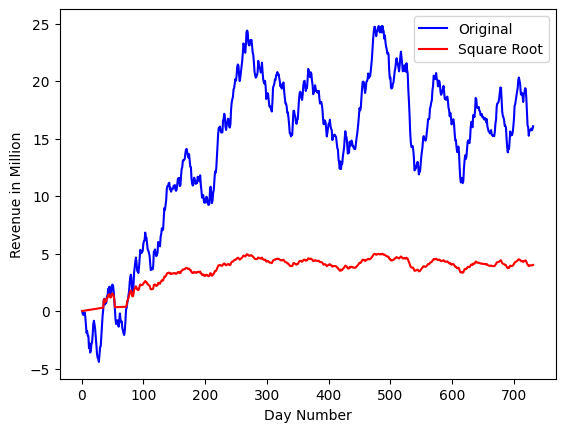

In [10]:
#take sqrt of dataset to establish stationarity
med_sqrt=np.sqrt(med['revenue'])
med_sqrt = med_sqrt.replace([np.inf,-np.inf],np.nan)
med_sqrt.dropna(inplace=True)
plt.ylabel('Revenue in Million')
plt.xlabel('Day Number')
orig=plt.plot(med['revenue'], color='blue', label='Original')
sqrt_plot=plt.plot(med_sqrt, color='red', label='Square Root')
plt.legend(loc='best')
plt.show(block=False)

In [11]:
#Check for stationarity of med_sqrt
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF: ", dftest[0])
  print("2. P-value: ", dftest[1])
  print("3. Num of Lags:", dftest[2])
  print("4. Num of Obsd Used for ADF Regression and Critical Values Calc:", dftest[3])
  print("5. Critical Values: ")
  for key, val in dftest[4].items():
    print("\t",key,": ", val)
ad_test(med_sqrt)

1. ADF:  -3.5034640096254472
2. P-value:  0.007898575349374527
3. Num of Lags: 3
4. Num of Obsd Used for ADF Regression and Critical Values Calc: 677
5. Critical Values: 
	 1% :  -3.4400461122487807
	 5% :  -2.8658186431652357
	 10% :  -2.5690485069240654


In [12]:
med_sqrt.head(10)

,revenue
Day,
1,0.000000
35,0.298074
36,0.993384
37,1.035416
38,0.758478
39,0.882313
40,0.855548
41,1.125792
42,1.130332


In [13]:
med_sqrt.shape

(681,)

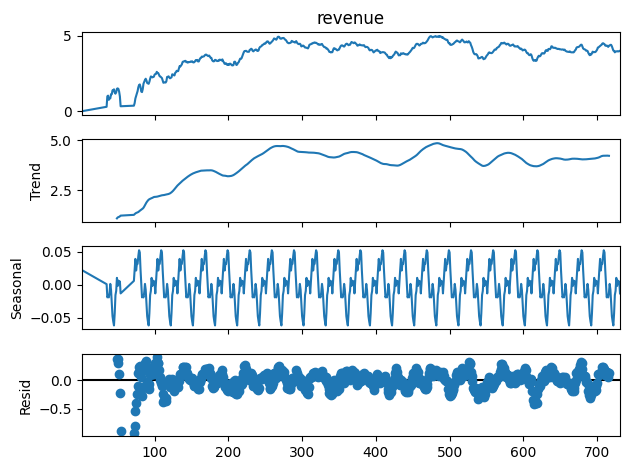

In [14]:
#Decomposition of med_sqrt
decomp = seasonal_decompose(med_sqrt, model='additive', period=30)
decomp.plot()
plt.show()

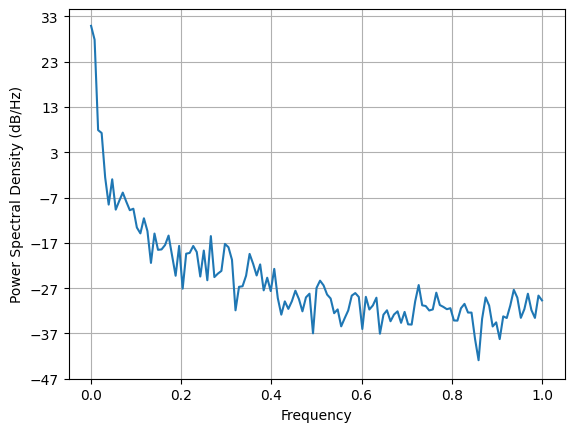

In [15]:
#plot spectral density to check for seasonality
plt.psd(med_sqrt)
plt.show()

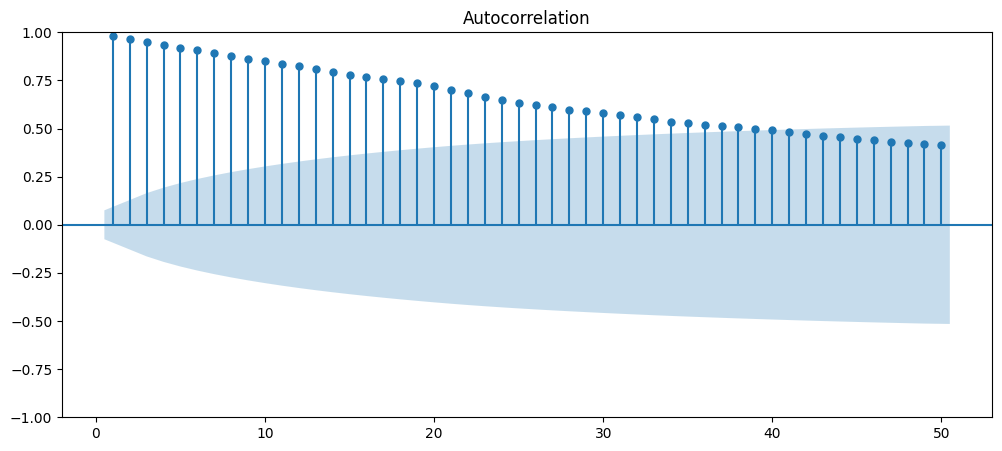

In [16]:
#plot ACF
from statsmodels.graphics.tsaplots import plot_acf
fig, ax1 = plt.subplots(figsize=(12,5))
plot_acf(med_sqrt, lags=50, zero=False, ax=ax1)
plt.show()

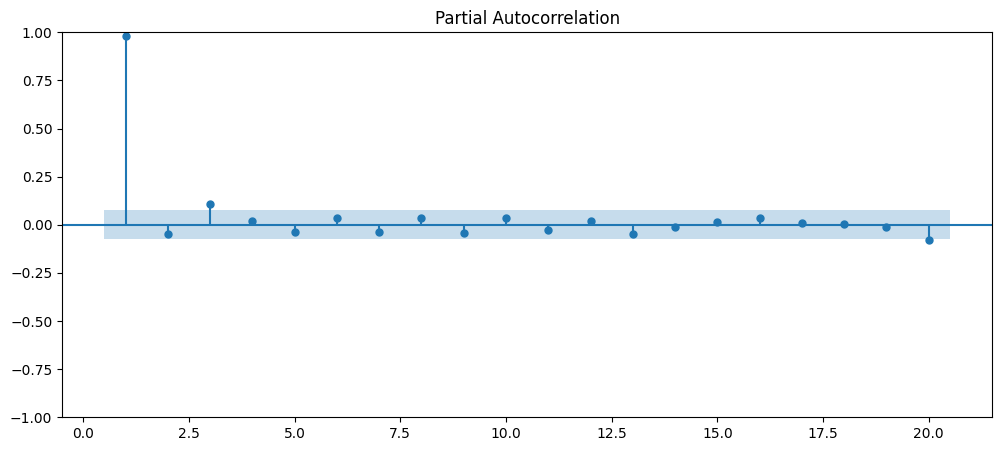

In [17]:
#plot pacf
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax1 = plt.subplots(figsize=(12,5))
plot_pacf(med_sqrt, lags=20, zero=False, ax=ax1)
plt.show()

ACF tails off and PACF cuts off --> AR(2) model --> model order (2,1,0)

In [18]:
#export differenced medical dataset
med_sqrt.to_csv('med_sqrt.csv')

In [19]:
#create a train and test dataset from original dataset
train=med.iloc[:-120]
test=med.iloc[-120:]
print(train.shape)
print(test.shape)

(611, 1)
(120, 1)


In [20]:
#export train and test dataset
train.to_csv('train.csv')
test.to_csv('test.csv')

In [21]:
auto_arima_model = auto_arima(med['revenue'], start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=False,
                              d=1, D=1, trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
print(auto_arima_model.aic())
print(auto_arima_model.summary())

Performing stepwise search to minimize aic


/root/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=1.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=2.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=4.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=1.76 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 14.164 seconds
879.9818304707812
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Tue, 20 May 2025   AIC                            879.982
Time:                        16:17:03   BIC                            889.168
Sample:                             0   HQIC                           883.526
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      

In [22]:
#ARIMA model based on autoarima recommended parameters
model = ARIMA(train['revenue'], order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  611
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -364.398
Date:                Tue, 20 May 2025   AIC                            732.795
Time:                        16:17:03   BIC                            741.622
Sample:                             0   HQIC                           736.229
                                - 611                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4071      0.037     10.961      0.000       0.334       0.480
sigma2         0.1933      0.012     16.148      0.000       0.170       0.217
Ljung-Box (L1) (Q):                   0.11   Jarque-

In [23]:
#manual ARIMA p,d,q parameters
manual = ARIMA(train['revenue'], order=(2,1,0))
manual = manual.fit()
print(manual.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  611
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -364.108
Date:                Tue, 20 May 2025   AIC                            734.216
Time:                        16:17:04   BIC                            747.456
Sample:                             0   HQIC                           739.366
                                - 611                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3944      0.040      9.821      0.000       0.316       0.473
ar.L2          0.0309      0.043      0.710      0.477      -0.054       0.116
sigma2         0.1931      0.012     15.884      0.0

In [24]:
#manual ARIMA p,d,q parameters
manual = ARIMA(train['revenue'], order=(1,1,1))
manual = manual.fit()
print(manual.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  611
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -364.191
Date:                Tue, 20 May 2025   AIC                            734.382
Time:                        16:17:04   BIC                            747.622
Sample:                             0   HQIC                           739.532
                                - 611                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4524      0.097      4.687      0.000       0.263       0.642
ma.L1         -0.0542      0.107     -0.509      0.611      -0.263       0.155
sigma2         0.1932      0.012     15.916      0.0

In [25]:
#make prediction
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start, end=end, typ='levels')
print(pred)

611    13.614986
612    13.533949
613    13.500961
614    13.487531
615    13.482064
         ...    
726    13.478311
727    13.478311
728    13.478311
729    13.478311
730    13.478311
Name: predicted_mean, Length: 120, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [26]:
#set index
pred.index=med.index[start:end+1]
print(pred)

Day
612    13.614986
613    13.533949
614    13.500961
615    13.487531
616    13.482064
         ...    
727    13.478311
728    13.478311
729    13.478311
730    13.478311
731    13.478311
Name: predicted_mean, Length: 120, dtype: float64


In [27]:
#calculate confidence interval
confidence_interval=model_fit.get_prediction(start=start, end=end, typ='levels')
confidence_interval=confidence_interval.conf_int()
confidence_interval.index=med.index[start:end+1]
print(confidence_interval)

     lower revenue  upper revenue
Day                              
612      12.753244      14.476727
613      12.046378      15.021521
614      11.488535      15.513387
615      11.028300      15.946762
616      10.633689      16.330440
..             ...            ...
727      -2.095914      29.052536
728      -2.163584      29.120206
729      -2.230963      29.187584
730      -2.298053      29.254675
731      -2.364860      29.321482

[120 rows x 2 columns]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
#assign confidence interval
lower_limits=confidence_interval.loc[:,'lower revenue']
upper_limits=confidence_interval.loc[:,'upper revenue']
print(lower_limits)
print(upper_limits)

Day
612    12.753244
613    12.046378
614    11.488535
615    11.028300
616    10.633689
         ...    
727    -2.095914
728    -2.163584
729    -2.230963
730    -2.298053
731    -2.364860
Name: lower revenue, Length: 120, dtype: float64
Day
612    14.476727
613    15.021521
614    15.513387
615    15.946762
616    16.330440
         ...    
727    29.052536
728    29.120206
729    29.187584
730    29.254675
731    29.321482
Name: upper revenue, Length: 120, dtype: float64


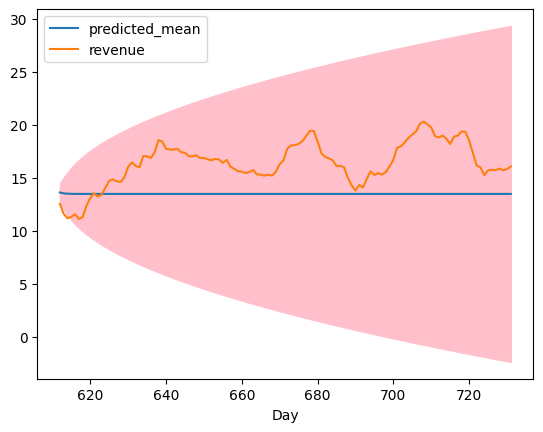

In [29]:
#plot test data
pred.plot(legend=True)
test['revenue'].plot(legend=True)
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.show()

In [30]:
#export prediction from model
pred=pd.DataFrame(pred)
pred.columns=['revenue']
pred.index.name='day'
confidence_interval=pd.DataFrame(confidence_interval)
confidence_interval.columns=['lower revenue', 'upper revenue']
confidence_interval.index.name='day'
pred['lower revenue']=confidence_interval['lower revenue']
pred['upper revenue']=confidence_interval['upper revenue']
pred.to_csv('pred.csv')

In [31]:
#summary of pred
pred.describe()

,revenue,lower revenue,upper revenue
count,120.000000,120.000000,120.000000
mean,13.480232,2.947350,24.013113
std,0.013581,3.814457,3.805018
min,13.478311,-2.364860,14.476727
25%,13.478311,-0.238878,21.382209
50%,13.478311,2.283828,24.672794
75%,13.478311,5.574413,27.195499
max,13.614986,12.753244,29.321482


In [32]:
#average of test dataset
test['revenue'].mean()

16.364266721750003

In [33]:
#check error
MSE=mean_squared_error(test['revenue'], pred['revenue'])
print('MSE:', MSE)
rmse = sqrt(mean_squared_error(test, pred['revenue']))
print('RMSE:',rmse)

MSE: 12.506952243744252
RMSE: 3.5365169650016175


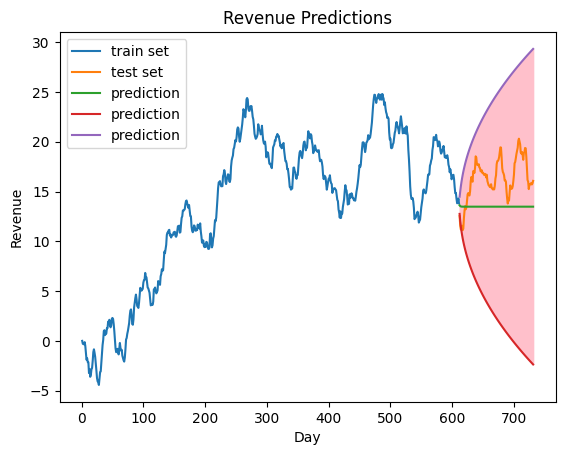

In [34]:
#graph prediction against test dataset
plt.plot(train, label = 'train set')
plt.plot(test, label = 'test set')
plt.plot(pred, label = 'prediction')
plt.title('Revenue Predictions')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc='upper left')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.show()

In [35]:
#create forecast into the next quarter
model2 = ARIMA(med['revenue'], order=(1,1,0))
model_fit2 = model2.fit()
start=len(med)
end=len(med)+119
forecast=model_fit2.predict(start=start, end=end, typ='levels')
print(forecast)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


731    16.171559
732    16.213862
733    16.231384
734    16.238642
735    16.241649
         ...    
846    16.243774
847    16.243774
848    16.243774
849    16.243774
850    16.243774
Name: predicted_mean, Length: 120, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [36]:
#calculate confidence interval
confidence_interval2=model_fit2.get_prediction(start=start, end=end, typ='levels')
confidence_interval2=confidence_interval2.conf_int()
print(confidence_interval2)

     lower revenue  upper revenue
731      15.307544      17.035573
732      14.717345      17.710378
733      14.202382      18.260386
734      13.755465      18.721819
735      13.362594      19.120703
..             ...            ...
846       0.440808      32.046741
847       0.372125      32.115424
848       0.303738      32.183811
849       0.235643      32.251906
850       0.167836      32.319713

[120 rows x 2 columns]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [37]:
#assign confidence interval
lower_limits2=confidence_interval2.loc[:,'lower revenue']
upper_limits2=confidence_interval2.loc[:,'upper revenue']
print(lower_limits2)
print(upper_limits2)

731    15.307544
732    14.717345
733    14.202382
734    13.755465
735    13.362594
         ...    
846     0.440808
847     0.372125
848     0.303738
849     0.235643
850     0.167836
Name: lower revenue, Length: 120, dtype: float64
731    17.035573
732    17.710378
733    18.260386
734    18.721819
735    19.120703
         ...    
846    32.046741
847    32.115424
848    32.183811
849    32.251906
850    32.319713
Name: upper revenue, Length: 120, dtype: float64


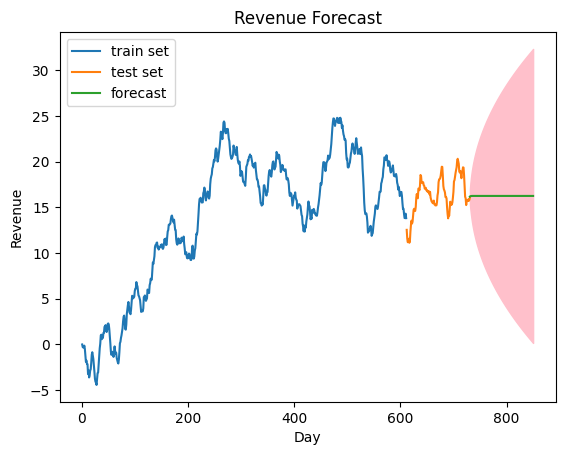

In [38]:
#graph train, test, and forecast together
plt.plot(train.index, train, label = 'train set')
plt.plot(test.index, test, label = 'test set')
plt.plot(forecast.index, forecast, label = 'forecast')
plt.title('Revenue Forecast')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc='upper left')
plt.fill_between(forecast.index, lower_limits2, upper_limits2, color='pink')
plt.show()

In [39]:
forecast=pd.DataFrame(forecast)
forecast.columns=['revenue']
forecast.index.name='day'
confidence_interval2=pd.DataFrame(confidence_interval2)
confidence_interval2.columns=['lower revenue', 'upper revenue']
confidence_interval2.index.name='day'
forecast['lower revenue']=confidence_interval2['lower revenue']
forecast['upper revenue']=confidence_interval2['upper revenue']
forecast.describe()

,revenue,lower revenue,upper revenue
count,120.000000,120.000000,120.000000
mean,16.242747,5.557696,26.927798
std,0.007200,3.865863,3.870907
min,16.171559,0.167836,17.035573
25%,16.243774,2.325690,24.260479
50%,16.243774,4.886383,27.601165
75%,16.243774,8.227070,30.161859
max,16.243774,15.307544,32.319713


In [40]:
#mean of the medical dataset
med['revenue'].mean()

14.179608298902874

In [41]:
#export forecast as csv
forecast.to_csv('forecast.csv')